### **Step 1**

Scaled Data Preview:
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.866045      -0.031990       0.670643 -0.181541  0.166619   
1    -0.844885 -1.205066      -0.528319      -0.012301 -0.181541 -0.852200   
2     1.233880  2.016662      -0.693761      -0.012301 -0.181541 -1.332500   
3    -0.844885 -1.073567      -0.528319      -0.695245 -0.540642 -0.633881   
4    -1.141852  0.504422      -2.679076       0.670643  0.316566  1.549303   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.468492  1.425995      1.0  
1                 -0.365061 -0.190672      0.0  
2                  0.604397 -0.105584      1.0  
3                 -0.920763 -1.041549      0.0  
4                  5.484909 -0.020496      1.0  


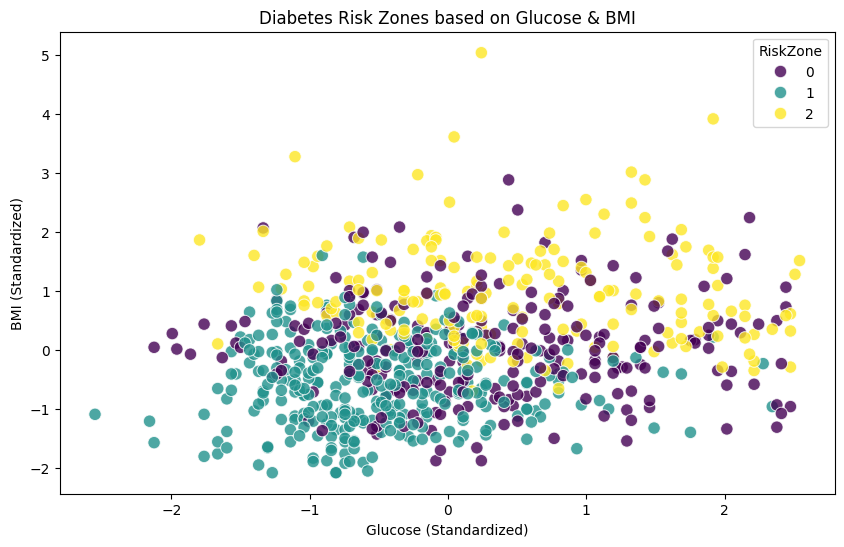


DSI Preview:
         DSI  RiskZone  Outcome
0  50.542836         0      1.0
1  18.336813         1      0.0
2  47.462047         0      1.0
3  14.963050         1      0.0
4  38.312192         2      1.0


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:22:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.81      0.84      0.82       100
           1       0.68      0.63      0.65        54

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154



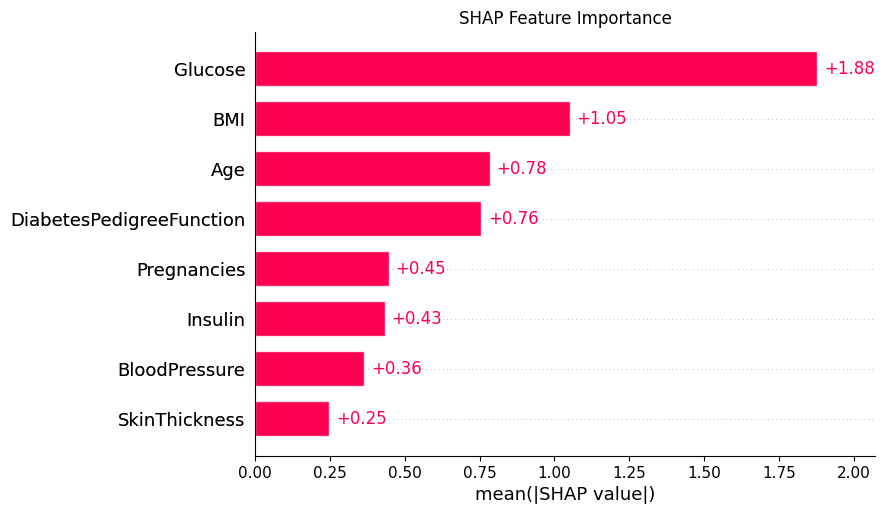

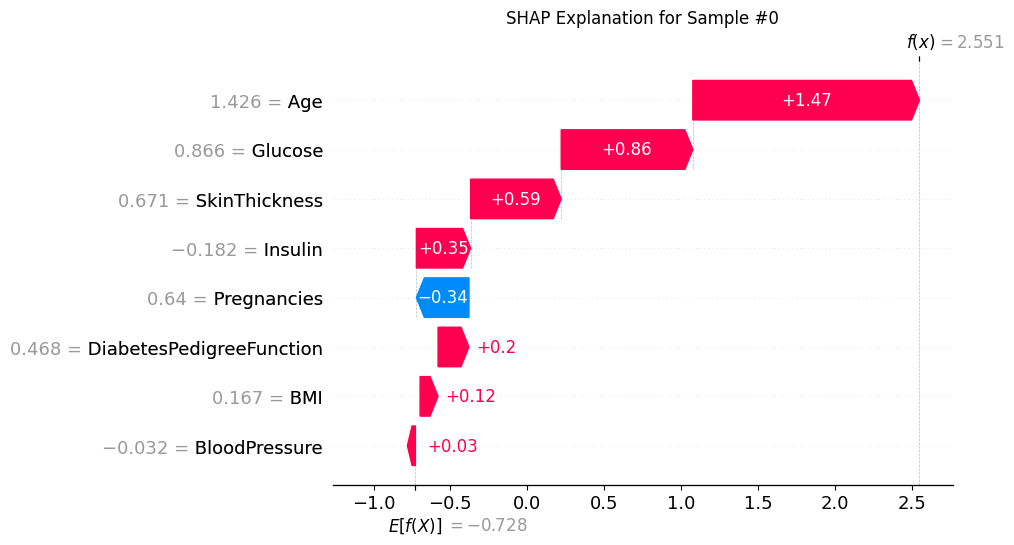

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import shap

# === STEP 1: DATA LOADING & PREPROCESSING ===
def load_and_preprocess_data(filepath):
    """Load data and replace invalid zeros with NaNs"""
    data = pd.read_csv(filepath)
    features_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    data[features_with_zero] = data[features_with_zero].replace(0, np.nan)
    return data

# === STEP 2: IMPUTATION & SCALING ===
def impute_and_scale(data):
    """Handle missing values and scale features"""
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    data_imputed = pd.DataFrame(
        imputer.fit_transform(data),
        columns=data.columns
    )

    X_scaled = pd.DataFrame(
        scaler.fit_transform(data_imputed.drop('Outcome', axis=1)),
        columns=data.columns[:-1]
    )
    X_scaled['Outcome'] = data_imputed['Outcome'].values
    return X_scaled

# === STEP 3: RISK ZONE CLUSTERING ===
def add_risk_zones(data, n_clusters=3):
    """Add risk zones using KMeans clustering"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    data['RiskZone'] = kmeans.fit_predict(data.drop('Outcome', axis=1))
    return data

# === STEP 4: DIABETES SEVERITY INDEX ===
def calculate_dsi(data):
    """Calculate Diabetes Severity Index"""
    weights = {
        'Glucose': 0.3,
        'Insulin': 0.2,
        'BMI': 0.15,
        'Age': 0.15,
        'BloodPressure': 0.1,
        'Pregnancies': 0.1
    }

    # Calculate weighted sum
    weighted_sum = sum(data[feature] * weight for feature, weight in weights.items())

    # Normalize to 0-100 scale
    data['DSI'] = (weighted_sum - weighted_sum.min()) / (weighted_sum.max() - weighted_sum.min()) * 100
    return data

# === STEP 5: MODEL TRAINING & EVALUATION ===
def train_and_evaluate(X, y):
    """Train XGBoost model and evaluate performance"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    return model, X_train, X_test

# === MAIN EXECUTION PIPELINE ===
if __name__ == "__main__":
    # Load and preprocess data
    data = load_and_preprocess_data("/content/diabetes.csv")

    # Impute and scale
    scaled_data = impute_and_scale(data)
    print("Scaled Data Preview:")
    print(scaled_data.head())

    # Add risk zones
    clustered_data = add_risk_zones(scaled_data)

    # Visualize clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Glucose',
        y='BMI',
        hue='RiskZone',
        data=clustered_data,
        palette='viridis',
        s=80,
        alpha=0.8
    )
    plt.title("Diabetes Risk Zones based on Glucose & BMI")
    plt.xlabel("Glucose (Standardized)")
    plt.ylabel("BMI (Standardized)")
    plt.show()

    # Calculate DSI
    final_data = calculate_dsi(clustered_data)
    print("\nDSI Preview:")
    print(final_data[['DSI', 'RiskZone', 'Outcome']].head())

    # Prepare modeling data
    model_data = final_data.drop(['RiskZone', 'DSI', 'Outcome'], axis=1)
    target = final_data['Outcome'].astype(int)

    # Train and evaluate model
    model, X_train, X_test = train_and_evaluate(model_data, target)

    # SHAP Analysis
    plt.title("SHAP Feature Importance")
    explainer = shap.Explainer(model)
    shap_values = explainer(model_data)
    shap.plots.bar(shap_values, max_display=10)

    # Waterfall plot for specific case
    sample_idx = 0  # First test sample
    plt.title(f"SHAP Explanation for Sample #{sample_idx}")
    shap.plots.waterfall(shap_values[sample_idx], max_display=10)
